In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
import random
import sklearn.metrics.pairwise
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm

In [2]:
class linear_kernel:
    def run(self, X, Y):
        return sklearn.metrics.pairwise.linear_kernel(X, Y)

class poly_kernel:
    def __init__(self, c0=1, d=3, gamma=None):
        self.c0 = c0
        self.d = d
        self.gamma = gamma
        
    def run(self, X, Y):
        return sklearn.metrics.pairwise.polynomial_kernel(X, Y, self.d, self.gamma, self.c0)
    
class sigmoid_kernel:
    def __init__(self, c0=1, gamma=2):
        self.c0 = c0
        self.gamma = gamma
        
    def run(self, X, Y):
        return sklearn.metrics.pairwise.sigmoid_kernel(X, Y, self.gamma, self.c0)


class rbf_kernel:
    def __init__(self, gamma=2):
        self.gamma = gamma
        
    def run(self, X, Y):
        return sklearn.metrics.pairwise.rbf_kernel(X, Y, self.gamma)
    


In [1]:
class SupportVectorDataDescription:
    def __init__(self, kernel="rbf", max_iterations=30000, opt_precision=0.001, C=0.5, coef0=1, degree=3, gamma=0.1):
        self.max_iterations = max_iterations
        self.kernel = kernel
        self.opt_precision = opt_precision
        self.coef0 = coef0
        self.degree = degree
        self.gamma = gamma
        self.C = C
        
    def _get_kernel(self, X, Y):
        if self.kernel == "poly":
            return poly_kernel(self.coef0, self.degree, self.gamma).run(X, Y)
        elif self.kernel == "rbf":
            return rbf_kernel(self.gamma).run(X, Y)
        elif self.kernel == "sigmoid":
            return sigmoid_kernel(self.coef0, self.gamma).run(X,Y)
        else:
            return linear_kernel().run(X, Y)
        
        
    def fit(self, X):
        self.X_fit_ = X
        
        K = self._get_kernel(X, X)
        
        self.K = K
        
        self.alfas = self.initialize_alpha(X)
        dist_to_center, dist_to_decision_boundary, R = self.smo(K)
        return self
        
    def smo(self, K):
        iteration = 0
        
        dist_to_center, dist_to_decision_boundary, R = self.calculate_predictions(K)
        
        while iteration < self.max_iterations:
            black_list = set()
            iteration += 1
            
            KKT_violation_idxs = []
            for i in range(self.alfas.shape[0]):
                if self.violates_KKT_condition(i, dist_to_decision_boundary) and not(i in black_list):
                    KKT_violation_idxs.append(i)
                    
            
            if len(KKT_violation_idxs) == 0:
                print("Finished optimization. No more violations.")
                self.dist_to_center_ = dist_to_center
                
                self.R = R
                return dist_to_center, dist_to_decision_boundary, R
            else:
                dist_to_center, dist_to_decision_boundary, R = self.examine_and_update_predictions(R, dist_to_center,
                                                                                             dist_to_decision_boundary,
                                                                                             KKT_violation_idxs,
                                                                                             black_list,
                                                                                             K)
    
            sv_larger_than_zero = self.alfas > self.opt_precision
            sv_smaller_than_C = self.alfas < (self.C - self.opt_precision)
        
            sv_larger_than_zero_idx = np.where(sv_larger_than_zero)
            sv_smaller_than_C_idx = np.where(sv_smaller_than_C)
        
            SV_nb = np.intersect1d(sv_larger_than_zero_idx, sv_smaller_than_C_idx)
            KKT_violations_in_SV_nb = []
            for i in SV_nb:
                if self.violates_KKT_condition(i, dist_to_decision_boundary) and not(i in black_list):
                    KKT_violations_in_SV_nb.append(i)
            
        
            while len(KKT_violations_in_SV_nb) > 0 and iteration < self.max_iterations:
                iteration += 1
                dist_to_center, dist_to_decision_boundary, R = self.examine_and_update_predictions(R, dist_to_center,
                                              dist_to_decision_boundary,
                                              KKT_violations_in_SV_nb,
                                              black_list,
                                              K)
                KKT_violations_in_SV_nb = []
                for i in SV_nb:
                    if self.violates_KKT_condition(i, dist_to_decision_boundary) and not(i in black_list):
                        KKT_violations_in_SV_nb.append(i)
                        
        print("Reached maximum iterations")
        self.R = R
        self.dist_to_center_ = dist_to_center
        return dist_to_center, dist_to_decision_boundary, R
    
    
    def predict(self, X_new):
        return np.sign(self.decision_function(X_new))
    
    def decision_function(self, X_new):
        ct_term = np.sum(np.multiply(np.dot(self.alfas.reshape(-1, 1), self.alfas.reshape(1, -1)), self.K))
        
        
        first_term = self._get_kernel(X_new, X_new)
        first_term = first_term.diagonal()
        
        
        second_term =  np.multiply(self._get_kernel(X_new, self.X_fit_), self.alfas)
        second_term = 2 * np.sum(second_term, axis=1)
        
        distances_to_center = first_term - second_term + ct_term
        distance_to_decision_boundary = distances_to_center - self.R
        
        return -distance_to_decision_boundary
    
    '''
    Auxilary function for computing a term in the formula of the update of alphas
    '''
    def comp_c(self, i, i1, i2, K):
        c_i = 0
        for j in range(self.alfas.shape[0]):
            if j == i1 or j == i2:
                continue
            
            c_i += self.alfas[j] * K[i][j]
            
        
        return c_i
    
    '''
    - Updates the chosed alphas i1 and i2 which violate the KKT conditions
    - Update rule is analytically computed by computing the derivative of the L, keeping all other
    alphas fixed and deriving w.r.t alpha_i1 and alpha_i2
    - After the update, clip the alphas to the allowed interval. 
    '''
    def update_alphas(self, i1, i2, K):
        if i1 == i2:
            return False
        
        L = max(0, self.alfas[i1] + self.alfas[i2] - self.C)
        H = min(self.C, self.alfas[i1] + self.alfas[i2])
        
        if abs(L - H) < self.opt_precision:
            return False
        
        
        delta = self.alfas[i1] + self.alfas[i2]
        
        c_i1 = self.comp_c(i1, i1, i2, K)
        c_i2 = self.comp_c(i2, i1, i2, K)
        
        alpha2 = (2 * delta * (K[i1, i1] - K[i1,i2]) + c_i1 - c_i2 - K[i1, i1] + K[i2, i2]) / (2 * K[i1,i1] - 4 * K[i1,i2] + 2 * K[i2,i2])
        
        if alpha2 > H:
            alpha2 = H
        elif alpha2 < L:
            alpha2 = L
            
        if abs(self.alfas[i2] - alpha2) < self.opt_precision * (alpha2 + self.alfas[i2] + self.opt_precision):
            return False
        else:
            alpha1 = delta - alpha2
            self.alfas[i1] = alpha1
            self.alfas[i2] = alpha2
            return True
    

    '''
    Heuristic for picking the second alpha to optimize, once we have the firs alpha, acording to:
    B. Schölkopf, J. C. Platt, J. Shawe-Taylor, A. J. Smola, and R. C. Williamson,
    "Estimating the support of a high-dimensional distribution,"" Neural Comput., 2001.
    '''
    def second_choice(self, i2, distances_to_center):
        sv_larger_than_zero = self.alfas > self.opt_precision
        sv_smaller_than_C = self.alfas < (self.C - self.opt_precision)

        sv_larger_than_zero_idx = np.where(sv_larger_than_zero)
        sv_smaller_than_C_idx = np.where(sv_smaller_than_C)

        SV_nb = np.intersect1d(sv_larger_than_zero_idx, sv_smaller_than_C_idx)

        if len(SV_nb) == 0:
            SV_nb = np.intersect1d(sv_larger_than_zero_idx, sv_larger_than_zero_idx)
    
        return SV_nb[np.argmax(np.abs(distances_to_center[i2] - [distances_to_center[index] for index in SV_nb]))]
        
    '''
    The second option -fallback-, in case the first choice of alpha_i1 does not work well, as presented in:
    J. Platt, "Sequential minimal optimization: A fast algorithm for training support vector machines," 1998.
    '''    
    def examine_example(self, i2, K, distances_to_center):
        i1 = self.second_choice(i2, distances_to_center)
        
        if self.update_alphas(i1, i2, K):
            return True
        
        sv_larger_than_zero = self.alfas > self.opt_precision
        sv_smaller_than_C = self.alfas < (self.C - self.opt_precision)
        
        sv_larger_than_zero_idx = np.where(sv_larger_than_zero)
        sv_smaller_than_C_idx = np.where(sv_smaller_than_C)
        
        candidates = np.intersect1d(sv_larger_than_zero_idx, sv_smaller_than_C_idx)
        
        if len(candidates) != 0:
            np.random.shuffle(candidates)
            for i1 in candidates:
                if self.update_alphas(i1, i2, K):
                    return True
        
        rng = np.array(range(self.alfas.shape[0]))
        np.random.shuffle(rng)
        for i1 in rng:
            if self.update_alphas(i1, i2, K):
                return True
        
        return False
            
    
    '''
    Picks an alpha_i2 from the violating KKT alphas, picks a value for alpha_i1 and then computes the distances
    to obtain the predicitons (inside or outside the ball)
    
    
    If we can't make a step, we add alpha_i2 to a black_list, as described in:
    J. Platt, "Sequential minimal optimization: A fast algorithm for training support vector machines," 1998.
    '''
    def examine_and_update_predictions(self, R, dist_to_center, dist_to_decision_boundary, KKT_violation_idxs, black_list, K):
        i2 = random.choice(KKT_violation_idxs)
        
        if (self.examine_example(i2, K, dist_to_center)):
            dist_to_center, dist_to_decision_boundary, R = self.calculate_predictions(K)
        else:
            black_list.add(i2)
            
        return dist_to_center, dist_to_decision_boundary, R
    
    '''
    Initialize alphas according to B. Schölkopf, J. C. Platt, J. Shawe-Taylor, A. J. Smola,
    and R. C. Williamson, "Estimating the support of a high-dimensional distribution,"" Neural Comput., 2001.
    '''
    def initialize_alpha(self, X):
        n_init = int(1/self.C) + 1
        self.alfas = np.zeros(X.shape[0])
        
        self.alfas[random.sample(range(X.shape[0]), n_init)] = 1/n_init
        return self.alfas
    
    
    '''
    Computes for every point, the distance to the center of the ball and decides whether it lies inside or outside
    the ball, by comparing with the ball radius. 
    '''
    def calculate_predictions(self, K):
        sv_larger_than_zero = self.alfas > self.opt_precision
        sv_smaller_than_C = self.alfas < (self.C - self.opt_precision)
        
        sv_larger_than_zero_idx = np.where(sv_larger_than_zero)
        sv_smaller_than_C_idx = np.where(sv_smaller_than_C)
        
        
        ct_term = 0
        for i in np.nditer(sv_larger_than_zero_idx):
            for j in np.nditer(sv_larger_than_zero_idx):
                ct_term += self.alfas[i] * self.alfas[j] * K[i][j]
        
        distances_to_center = []
        
        for z in range(self.alfas.shape[0]):
            s = 0
            for i in np.nditer(sv_larger_than_zero_idx):
                s += self.alfas[i] * K[i][z]
            
            distances_to_center.append(K[z][z] - 2 * s + ct_term)
       
        sv_between_zero_and_C = np.intersect1d(sv_larger_than_zero_idx, sv_smaller_than_C_idx)
    
    # Sometimes some numerical error appear so we use the solution from:
    # W.-C. Chang, C.-P. Lee, and C.-J. Lin, "A revisit to support vector data description,"Nat. Taiwan Univ., Tech. Rep, 2013.
    
        if (len(sv_between_zero_and_C) != 0):
            R = np.mean(np.array(distances_to_center)[sv_between_zero_and_C])
        else:
            R = ((np.min(np.array(distances_to_center)[sv_larger_than_zero_idx])) + (np.max(np.array(distances_to_center)[sv_larger_than_zero_idx]))) / 2
            
            
        distance_to_decision_boundary = distances_to_center - R
        
        return distances_to_center, distance_to_decision_boundary, R
    
    '''
    Check if alpha_i2 violates the KKT conditions - Points inside the sphere must have alpha=0 and
    points outside the circle must have alpha=C
    '''
    def violates_KKT_condition(self, i2, dist_to_decision_boundary):
        cond1 = (self.alfas[i2] > self.opt_precision and dist_to_decision_boundary[i2] < -self.opt_precision)
        # inside the decision boundary, but alfa != 0
        
        cond2 = (self.alfas[i2] < self.C - self.opt_precision and dist_to_decision_boundary[i2] > self.opt_precision)
        # outside the decision boundary, but alfa != C
    
        return (cond1 or cond2)
    
        


# Generate the dataset

In [354]:
# Define datasets
datasets = [
    (make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3], n_samples=100, n_features=2)[0],
    0.5 * np.random.randn(20, 2),
    np.random.uniform(low=-4, high=4, size=(20, 2))),
# (X_train, X_test, X_outliers)
]



Reached maximum iterations
Reached maximum iterations
Reached maximum iterations


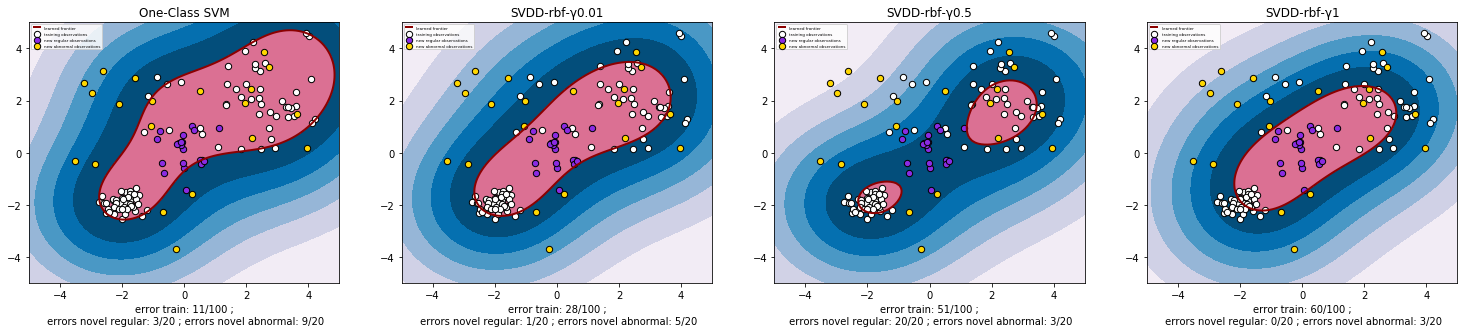

In [360]:
# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("One-Class SVM", svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)),
    ("SVDD-rbf-γ0.01", SupportVectorDataDescription(max_iterations=3000, C=.03, kernel="rbf", gamma=0.1)),
    ("SVDD-rbf-γ0.5", SupportVectorDataDescription(max_iterations=3000, C=.1, kernel="rbf", gamma=0.1)),
    ("SVDD-rbf-γ1", SupportVectorDataDescription(max_iterations=3000, C=1, kernel="rbf", gamma=0.1)),
]


# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))


plt.figure(figsize=(len(anomaly_algorithms) * 6.4, len(datasets) * 4.8))

plot_num = 1

for i_dataset, X in enumerate(datasets):
    X_train = X[0]
    X_test = X[1]
    X_outliers = X[2]

    for name, algorithm in anomaly_algorithms:
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        
        algorithm.fit(X_train)
        y_pred_train = algorithm.predict(X_train)
        y_pred_test = algorithm.predict(X_test)
        y_pred_outliers = algorithm.predict(X_outliers)
        n_error_train = y_pred_train[y_pred_train == -1].size
        n_error_test = y_pred_test[y_pred_test == -1].size
        n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
        
        
        # plot the line, the points, and the nearest vectors to the plane
        Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.title(name)
        plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
        a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
        plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

        s = 40
        b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
        b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s, edgecolors='k')
        c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s, edgecolors='k')
        plt.axis('tight')
        plt.xlim((-5, 5))
        plt.ylim((-5, 5))
        plt.legend([a.collections[0], b1, b2, c],
                   ["learned frontier", "training observations",
                    "new regular observations", "new abnormal observations"],
                   loc="upper left",
                   prop=matplotlib.font_manager.FontProperties(size=4))
        plt.xlabel(
            "error train: %d/100 ;\n errors novel regular: %d/20 ; "
            "errors novel abnormal: %d/20"
            % (n_error_train, n_error_test, n_error_outliers))


        plot_num += 1
        
plt.savefig("testing1" + '.png', dpi=300)
plt.show() 
